In [6]:
import dask
from dask.distributed import Client, wait
from dask import delayed

client = Client(n_workers=7, threads_per_worker=1) 
#client = Client()

client

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41669 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41669/status,
Dashboard: /proxy/41669/status,Workers: 7
Total threads: 7,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35079,Workers: 7
Dashboard: /proxy/41669/status,Total threads: 7
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:37623,Total threads: 1
Dashboard: /proxy/37449/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:41387,


2025-09-23 14:38:17,391 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37623'.


In [30]:
#import all the stuff
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import glob
import sys
import cftime
sys.path.append("/g/data/mn51/users/nb6195/project/gwls/")
import gwl

In [8]:
def location_coords(location_dict, loc_name):
    lat_ind = round((location_dict[loc_name][0] + 44.5)/0.05)
    lon_ind = round((location_dict[loc_name][1] - 112)/0.05)
    return [lat_ind, lon_ind]

In [9]:
#Set parameters
CMIP='CMIP6'
#AGENCY = 'CSIRO' 
#RCM = 'CCAM-v2203-SN'
AGENCY = 'BOM' 
RCM = 'BARPA-R'

#GCM = 'ACCESS-CM2' #ensemble = 'r4i1p1f1' #Done
#GCM = 'ACCESS-ESM1-5' ensemble = 'r6i1p1f1' #Done
#GCM = 'EC-Earth3' ensemble = 'r1i1p1f1' #Done
#GCM = 'MPI-ESM1-2-HR' ensemble = 'r1i1p1f1' #BOM done, no CSIRO
#GCM = 'CESM2' ensemble = 'r11i1p1f1' #Done
#GCM = 'CMCC-ESM2' ensemble = 'r1i1p1f1' #Done
GCM = 'NorESM2-MM' 
ensemble = 'r1i1p1f1' #Done
#GCM = 'CNRM-ESM2-1' ensemble = 'r1i1p1f2' #CSIRO Done, no BOM

#pathway = 'ssp126'
pathway = 'ssp370'

ddir = f"/g/data/kj66/CORDEX/output-{CMIP}/DD/AUST-05i/{AGENCY}/{GCM}"
bdir = f"/g/data/kj66/CORDEX/output-{CMIP}/bias-adjusted-output/AUST-05i/{AGENCY}/{GCM}"

output_dir = '/g/data/ia39/ncra/bushfire/dwi/'

test_index = 'dwi' 
#test_index = 'faux_ffdi'
#test_index = 'p_ffdi'

chosen_gwl = '3.0'

Import tha data for the downscaled, MRNBC, and QME for the chosen index and GWL

In [10]:
#downscaled data
#need to adjust the variable based on the timing of the dataset creation and code version
infiles_d=f"/g/data/ia39/ncra/bushfire/dwi/{GCM}/{pathway}/{ensemble}/{RCM}/v1-r1/day/{pathway}_{GCM}_{RCM}_gwl{chosen_gwl}_{test_index}.nc"
#data_d = xr.open_dataset(infiles_m)[test_index]
data_d = xr.open_dataset(infiles_d)['__xarray_dataarray_variable__']

#MRNBC data
infiles_m=f"/g/data/ia39/ncra/bushfire/dwi/{GCM}/{pathway}/{ensemble}/{RCM}/v1-r1/day/{pathway}_{GCM}_{RCM}_MRNBC_gwl{chosen_gwl}_{test_index}.nc"
data_m = xr.open_dataset(infiles_m)[test_index]

#QME data
infiles_q=f"/g/data/ia39/ncra/bushfire/dwi/{GCM}/{pathway}/{ensemble}/{RCM}/v1-r1/day/{pathway}_{GCM}_{RCM}_QME_gwl{chosen_gwl}_{test_index}.nc"
data_q = xr.open_dataset(infiles_q)[test_index]

In [11]:
var1 = 'tasmaxAdjust'
var2 = 'hursminAdjust'
var3 = 'sfcWindmaxAdjust'

d_var1 = 'tasmax'
d_var2 = 'hursmin'
d_var3 = 'sfcWindmax'

In [12]:
#tasmax
m_infiles1a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
m_infiles1b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
MRNBC_tasmax_master_ds = xr.open_mfdataset(m_infiles1a + m_infiles1b)

q_infiles1a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
q_infiles1b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var1}/v20241216/{var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
QME_tasmax_master_ds = xr.open_mfdataset(q_infiles1a + q_infiles1b)

d_infiles1a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{d_var1}/v20241216/{d_var1}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
d_infiles1b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{d_var1}/v20241216/{d_var1}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
D_tasmax_master_ds = xr.open_mfdataset(d_infiles1a + d_infiles1b)

In [13]:
#hursmin
m_infiles2a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
m_infiles2b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
MRNBC_hursmin_master_ds = xr.open_mfdataset(m_infiles2a + m_infiles2b)

q_infiles2a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
q_infiles2b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var2}/v20241216/{var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
QME_hursmin_master_ds = xr.open_mfdataset(q_infiles2a + q_infiles2b)

d_infiles2a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{d_var2}/v20241216/{d_var2}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
d_infiles2b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{d_var2}/v20241216/{d_var2}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
D_hursmin_master_ds = xr.open_mfdataset(d_infiles2a + d_infiles2b)

In [14]:
#wind
m_infiles3a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
m_infiles3b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-MRNBC-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-MRNBC-BARRAR2-1980-2022_day_*.nc')
MRNBC_wind_sp_master_ds = xr.open_mfdataset(m_infiles3a + m_infiles3b)

q_infiles3a=glob.glob(bdir+f'/historical/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
q_infiles3b=glob.glob(bdir+f'/{pathway}/{ensemble}/{RCM}/v1-r1-ACS-QME-BARRAR2-1980-2022/day/{var3}/v20241216/{var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1-ACS-QME-BARRAR2-1980-2022_day_*.nc')
QME_wind_sp_master_ds = xr.open_mfdataset(q_infiles3a + q_infiles3b)

d_infiles3a=glob.glob(ddir+f'/historical/{ensemble}/{RCM}/v1-r1/day/{d_var3}/v20241216/{d_var3}_AUST-05i_{GCM}_historical_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
d_infiles3b=glob.glob(ddir+f'/{pathway}/{ensemble}/{RCM}/v1-r1/day/{d_var3}/v20241216/{d_var3}_AUST-05i_{GCM}_{pathway}_{ensemble}_{AGENCY}_{RCM}_v1-r1_day_*.nc')
D_wind_sp_master_ds = xr.open_mfdataset(d_infiles3a + d_infiles3b)

In [15]:
MRNBC_gwl_tasmax = gwl.get_GWL_timeslice(MRNBC_tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var1]
MRNBC_gwl_rh = gwl.get_GWL_timeslice(MRNBC_hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var2]
MRNBC_gwl_wind_sp = gwl.get_GWL_timeslice(MRNBC_wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var3]

QME_gwl_tasmax = gwl.get_GWL_timeslice(QME_tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var1]
QME_gwl_rh = gwl.get_GWL_timeslice(QME_hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var2]
QME_gwl_wind_sp = gwl.get_GWL_timeslice(QME_wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[var3]

D_gwl_tasmax = gwl.get_GWL_timeslice(D_tasmax_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[d_var1]
D_gwl_rh = gwl.get_GWL_timeslice(D_hursmin_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[d_var2]
D_gwl_wind_sp = gwl.get_GWL_timeslice(D_wind_sp_master_ds,CMIP,GCM,ensemble,pathway,GWL=chosen_gwl)[d_var3]

Choose the location from the set

In [16]:
location_dict = {
    'Adelaide' : [-34.95, 138.60],
    'Dandenongs' : [-37.8335, 145.3501],
    'Canberra' : [-35.2802, 149.1310],
    'Manjimup' : [-34.2432, 116.1453],
    'Cradle Mountain' : [-41.6800, 145.9400],
    'Kosciuszko' : [-36.4559, 148.2636],
    'Kuitpo' : [-35.2212, 138.6932],
    'Kinglake' : [-37.53291, 145.33964]
}

In [17]:
loc_name = 'Kinglake'

In [18]:
[lat_ind, lon_ind] = location_coords(location_dict, loc_name)

In [19]:
loc_data_d = data_d.isel(lat = lat_ind, lon = lon_ind)
loc_data_m = data_m.isel(lat = lat_ind, lon = lon_ind)
loc_data_q = data_q.isel(lat = lat_ind, lon = lon_ind)

In [20]:
loc_MRNBC_gwl_tasmax = MRNBC_gwl_tasmax.isel(lat = lat_ind, lon = lon_ind)
loc_MRNBC_gwl_rh = MRNBC_gwl_rh.isel(lat = lat_ind, lon = lon_ind)
loc_MRNBC_gwl_wind_sp = MRNBC_gwl_wind_sp.isel(lat = lat_ind, lon = lon_ind)

loc_QME_gwl_tasmax = QME_gwl_tasmax.isel(lat = lat_ind, lon = lon_ind)
loc_QME_gwl_rh = QME_gwl_rh.isel(lat = lat_ind, lon = lon_ind)
loc_QME_gwl_wind_sp = QME_gwl_wind_sp.isel(lat = lat_ind, lon = lon_ind)

loc_D_gwl_tasmax = D_gwl_tasmax.isel(lat = lat_ind, lon = lon_ind)
loc_D_gwl_rh = D_gwl_rh.isel(lat = lat_ind, lon = lon_ind)
loc_D_gwl_wind_sp = D_gwl_wind_sp.isel(lat = lat_ind, lon = lon_ind)

Monthly data

In [21]:
mean_loc_data_d = loc_data_d.groupby('time.month').mean('time', keep_attrs=True)
mean_loc_data_m = loc_data_m.groupby('time.month').mean('time', keep_attrs=True)
mean_loc_data_q = loc_data_q.groupby('time.month').mean('time', keep_attrs=True)

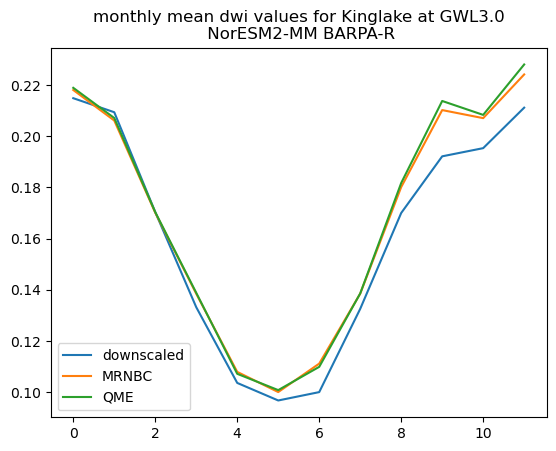

In [22]:
plt.plot(mean_loc_data_d, label = 'downscaled')
plt.plot(mean_loc_data_m, label = 'MRNBC')
plt.plot(mean_loc_data_q, label = 'QME')
plt.title('monthly mean %s values for %s at GWL%s\n %s %s' %(test_index, loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

In [23]:
#perc_loc_data_d = np.percentile(loc_data_d.groupby('time.month'), 90, axis='month')
perc_loc_data_d = loc_data_d.groupby('time.month').quantile(.9)
perc_loc_data_m = loc_data_m.groupby('time.month').quantile(.9)
perc_loc_data_q = loc_data_q.groupby('time.month').quantile(.9)

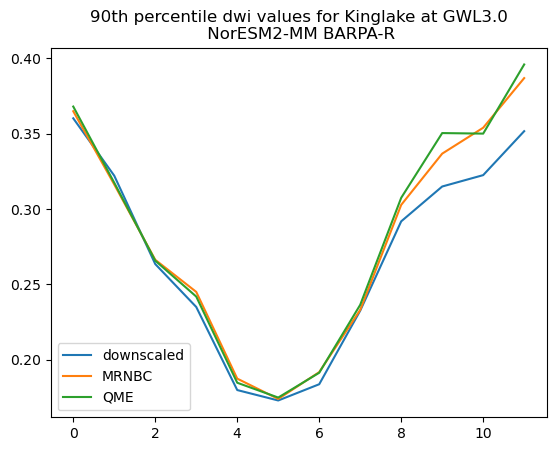

In [24]:
plt.plot(perc_loc_data_d, label = 'downscaled')
plt.plot(perc_loc_data_m, label = 'MRNBC')
plt.plot(perc_loc_data_q, label = 'QME')
plt.title('90th percentile %s values for %s at GWL%s\n %s %s' %(test_index, loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Examining the plots for Kinglake and Adelaide, the month with highest changes to monthly mean and 90th percentile values after BC for NorESM for GWL3.0 is October. For days over the thresholds of the mean and 90th percentile, look at the DWI and the input variables. 

In [28]:
mean_thresh_d = mean_loc_data_d[9]
perc_thresh_d = perc_loc_data_d[9]

In [55]:
#loc_data_d['year'] = loc_data_d['time'].dt.year
#loc_data_d['month'] = loc_data_d['time'].dt.month

In [49]:
#loc_data_d

In [64]:
oct_loc_data_d = loc_data_d[loc_data_d['time'].dt.month == 10]
oct_loc_data_m = loc_data_m[loc_data_d['time'].dt.month == 10]
oct_loc_data_q = loc_data_q[loc_data_d['time'].dt.month == 10]

In [83]:
#high days are the days when oct_loc_data_d > perc_thresh_d, create a conditional
high_data = oct_loc_data_d > perc_thresh_d

In [75]:
#high_data

In [84]:
high_oct_loc_data_d = oct_loc_data_d[high_data]
high_oct_loc_data_m = oct_loc_data_m[high_data]
high_oct_loc_data_q = oct_loc_data_q[high_data]

In [82]:
#high_oct_loc_data_d

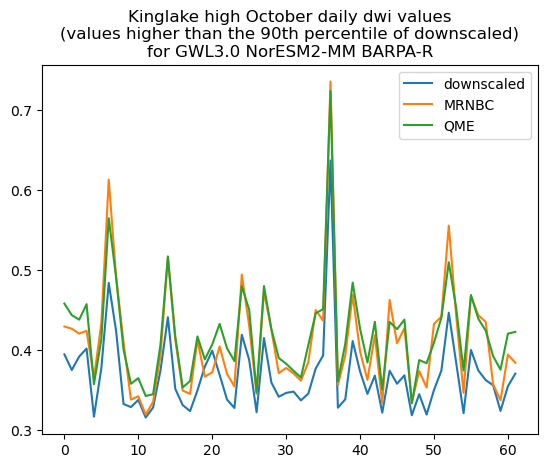

In [86]:
plt.plot(high_oct_loc_data_d, label = 'downscaled')
plt.plot(high_oct_loc_data_m, label = 'MRNBC')
plt.plot(high_oct_loc_data_q, label = 'QME')
plt.title('%s high October daily %s values\n(values higher than the 90th percentile of downscaled)\nfor GWL%s %s %s' %(loc_name, test_index, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Now let's look at the input variables in the same way

In [91]:
#temperature
oct_loc_T_data_d = loc_D_gwl_tasmax[loc_data_d['time'].dt.month == 10]
oct_loc_T_data_m = loc_MRNBC_gwl_tasmax[loc_data_d['time'].dt.month == 10]
oct_loc_T_data_q = loc_QME_gwl_tasmax[loc_data_d['time'].dt.month == 10]

high_oct_loc_T_data_d = oct_loc_T_data_d[high_data]
high_oct_loc_T_data_m = oct_loc_T_data_m[high_data]
high_oct_loc_T_data_q = oct_loc_T_data_q[high_data]

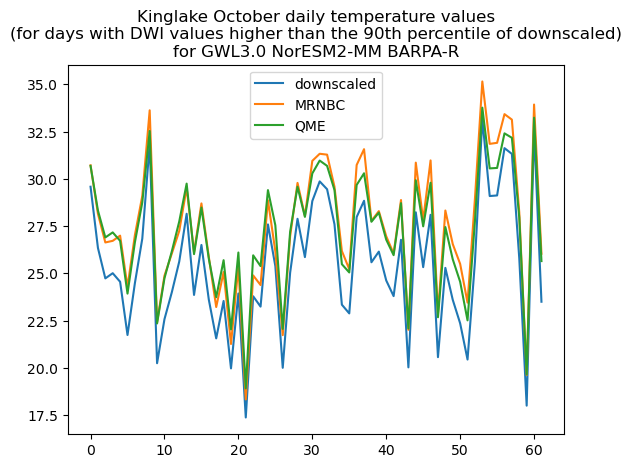

In [93]:
plt.plot(high_oct_loc_T_data_d, label = 'downscaled')
plt.plot(high_oct_loc_T_data_m, label = 'MRNBC')
plt.plot(high_oct_loc_T_data_q, label = 'QME')
plt.title('%s October daily temperature values\n(for days with DWI values higher than the 90th percentile of downscaled)\nfor GWL%s %s %s' %(loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

In [94]:
#RH
oct_loc_rh_data_d = loc_D_gwl_rh[loc_data_d['time'].dt.month == 10]
oct_loc_rh_data_m = loc_MRNBC_gwl_rh[loc_data_d['time'].dt.month == 10]
oct_loc_rh_data_q = loc_QME_gwl_rh[loc_data_d['time'].dt.month == 10]

high_oct_loc_rh_data_d = oct_loc_rh_data_d[high_data]
high_oct_loc_rh_data_m = oct_loc_rh_data_m[high_data]
high_oct_loc_rh_data_q = oct_loc_rh_data_q[high_data]

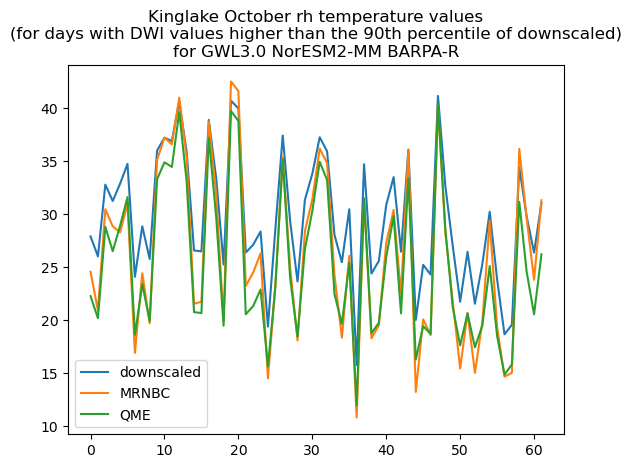

In [95]:
plt.plot(high_oct_loc_rh_data_d, label = 'downscaled')
plt.plot(high_oct_loc_rh_data_m, label = 'MRNBC')
plt.plot(high_oct_loc_rh_data_q, label = 'QME')
plt.title('%s October rh temperature values\n(for days with DWI values higher than the 90th percentile of downscaled)\nfor GWL%s %s %s' %(loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

In [96]:
#wind
oct_loc_wind_sp_data_d = loc_D_gwl_wind_sp[loc_data_d['time'].dt.month == 10]
oct_loc_wind_sp_data_m = loc_MRNBC_gwl_wind_sp[loc_data_d['time'].dt.month == 10]
oct_loc_wind_sp_data_q = loc_QME_gwl_wind_sp[loc_data_d['time'].dt.month == 10]

high_oct_loc_wind_sp_data_d = oct_loc_wind_sp_data_d[high_data]
high_oct_loc_wind_sp_data_m = oct_loc_wind_sp_data_m[high_data]
high_oct_loc_wind_sp_data_q = oct_loc_wind_sp_data_q[high_data]

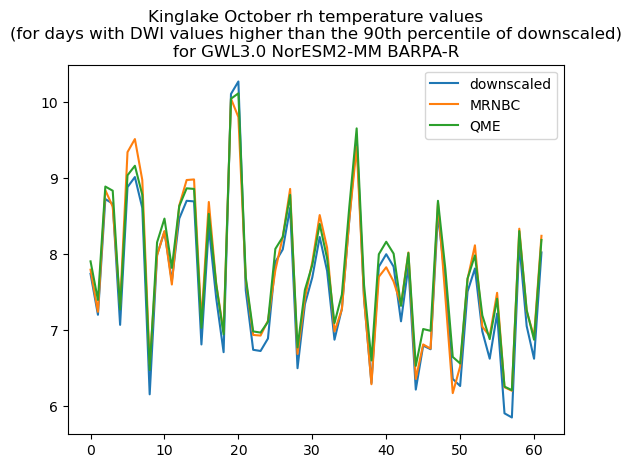

In [97]:
plt.plot(high_oct_loc_wind_sp_data_d, label = 'downscaled')
plt.plot(high_oct_loc_wind_sp_data_m, label = 'MRNBC')
plt.plot(high_oct_loc_wind_sp_data_q, label = 'QME')
plt.title('%s October rh temperature values\n(for days with DWI values higher than the 90th percentile of downscaled)\nfor GWL%s %s %s' %(loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Let's look at differences in the datasets

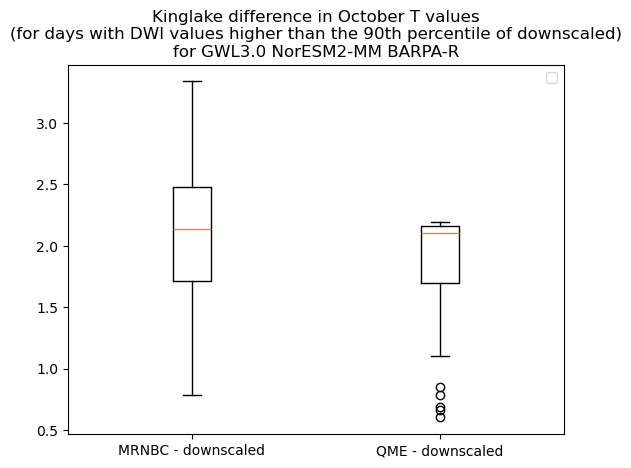

In [101]:
plot_data = [high_oct_loc_T_data_m - high_oct_loc_T_data_d, high_oct_loc_T_data_q - high_oct_loc_T_data_d]

plt.boxplot(plot_data, labels = ['MRNBC - downscaled', 'QME - downscaled'])
plt.title('%s difference in October T values\n(for days with DWI values higher than the 90th percentile of downscaled)\nfor GWL%s %s %s' %(loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

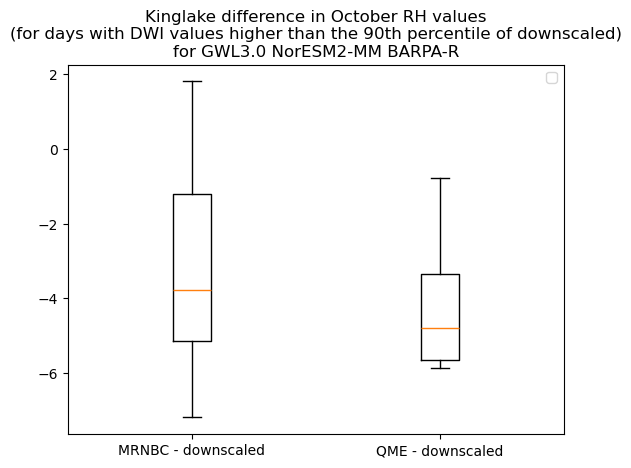

In [102]:
plot_data = [high_oct_loc_rh_data_m - high_oct_loc_rh_data_d, high_oct_loc_rh_data_q - high_oct_loc_rh_data_d]

plt.boxplot(plot_data, labels = ['MRNBC - downscaled', 'QME - downscaled'])
plt.title('%s difference in October RH values\n(for days with DWI values higher than the 90th percentile of downscaled)\nfor GWL%s %s %s' %(loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

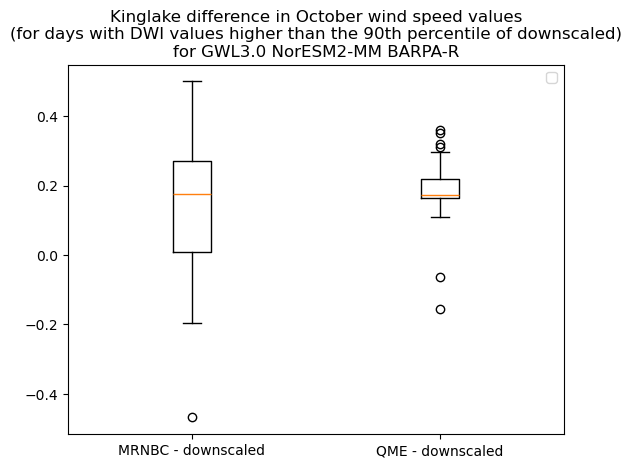

In [103]:
plot_data = [high_oct_loc_wind_sp_data_m - high_oct_loc_wind_sp_data_d, high_oct_loc_wind_sp_data_q - high_oct_loc_wind_sp_data_d]

plt.boxplot(plot_data, labels = ['MRNBC - downscaled', 'QME - downscaled'])
plt.title('%s difference in October wind speed values\n(for days with DWI values higher than the 90th percentile of downscaled)\nfor GWL%s %s %s' %(loc_name, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Code for location based investigation, plots are created around the max value within the 20 year period

In [1]:
#max_ind = loc_data_d.argmax()

In [2]:
#low_ind = max(int(max_ind - 20), 0)
#up_ind = low_ind + 40

Conversion of dates to be used as strings in plots

This one for ACCESS

In [88]:
#low_date_string = loc_data_d.time[low_ind].values.astype(str)[0:10]
#up_date_string = loc_data_d.time[up_ind].values.astype(str)[0:10]

This one for NorESM

In [3]:
#low_dt_no_leap = loc_data_d.time[low_ind].values

## Convert to a numeric time value
#low_numeric_time = cftime.date2num(low_dt_no_leap, units='days since 2000-01-01')

## Convert back to a standard datetime
#low_standard_datetime = cftime.num2date(low_numeric_time, units='days since 2000-01-01')

## Format as a string
#low_date_string = low_standard_datetime.strftime('%Y-%m-%d')

#loc_data_d.time[up_ind]

#up_dt_no_leap = loc_data_d.time[up_ind].values

## Convert to a numeric time value
#up_numeric_time = cftime.date2num(up_dt_no_leap, units='days since 2000-01-01')

## Convert back to a standard datetime
#up_standard_datetime = cftime.num2date(up_numeric_time, units='days since 2000-01-01')

## Format as a string
#up_date_string = up_standard_datetime.strftime('%Y-%m-%d')
##print(up_date_string)

In [4]:
plt.plot(loc_data_d[low_ind:up_ind], label = 'downscaled')
plt.plot(loc_data_m[low_ind:up_ind], label = 'MRNBC')
plt.plot(loc_data_q[low_ind:up_ind], label = 'QME')
plt.title('%s daily %s values from %s to %s\n(40 days centred on max %s value) for GWL%s\n %s %s' %(loc_name, test_index, low_date_string, up_date_string, test_index, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Plotting the input variables also

Plot for tasmax

In [ ]:
plt.plot(loc_D_gwl_tasmax[low_ind:up_ind], label = 'downscaled')
plt.plot(loc_MRNBC_gwl_tasmax[low_ind:up_ind], label = 'MRNBC')
plt.plot(loc_QME_gwl_tasmax[low_ind:up_ind], label = 'QME')
plt.title('%s daily %s values from %s to %s\n(40 days centred on max %s value) for GWL%s\n %s %s' %(loc_name, d_var1, low_date_string, up_date_string, test_index, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Plot for hursmin

In [ ]:
plt.plot(loc_D_gwl_rh[low_ind:up_ind], label = 'downscaled')
plt.plot(loc_MRNBC_gwl_rh[low_ind:up_ind], label = 'MRNBC')
plt.plot(loc_QME_gwl_rh[low_ind:up_ind], label = 'QME')
plt.title('%s daily %s values from %s to %s\n(40 days centred on max %s value) for GWL%s\n %s %s' %(loc_name, d_var2, low_date_string, up_date_string, test_index, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()

Plot for wind

In [ ]:
plt.plot(loc_D_gwl_wind_sp[low_ind:up_ind], label = 'downscaled')
plt.plot(loc_MRNBC_gwl_wind_sp[low_ind:up_ind], label = 'MRNBC')
plt.plot(loc_QME_gwl_wind_sp[low_ind:up_ind], label = 'QME')
plt.title('%s daily %s values from %s to %s\n(40 days centred on max %s value) for GWL%s\n %s %s' %(loc_name, d_var3, low_date_string, up_date_string, test_index, chosen_gwl, GCM, RCM))
plt.legend()
plt.show()